In [1]:
import os
import glob
import pickle
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from joblib import dump, load

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.model_selection import GridSearchCV

from acea.data_loaders import load_raw_data
from acea.configuration import cleaning_config, cols_to_avg_config, cols_to_drop_config
from acea.data_preparation import clean_data, create_features

%matplotlib inline

# Settings

In [2]:
FORECAST_PERIOD = 60
TEST_PERIOD = 30


In [3]:
datadir = '../data/raw/'
modeldir = '../models'

In [4]:
filename = 'Aquifer_Auser.csv'
target = 'Depth_to_Groundwater_COS'



# Load raw data

In [23]:

df = load_raw_data(os.path.join(datadir, filename))


In [24]:
df.head()

,Date,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,...,Temperature_Monte_Serra,Temperature_Ponte_a_Moriano,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
0,1998-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,10.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1998-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.2,0.0,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1998-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.4,0.0,13.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1998-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.4,0.0,12.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clean data

In [25]:
name = filename.replace('.csv', '') + '_' + target
body = filename.replace('.csv', '')


In [26]:
date_min = df['Date'].min()
date_max = df['Date'].max()
drop_cols = cleaning_config[body].get('drop_cols', [])
replace_cols = cleaning_config[body].get('replace_cols', [])
rename_cols = cleaning_config[body].get('rename_cols', {})
offsets = cleaning_config[body].get('offsets', [])

In [27]:
dfclean = clean_data(df, date_min, date_max, drop_cols=drop_cols, replace_cols=replace_cols, rename_cols=rename_cols, offsets=offsets)

shape (8154, 26)


In [28]:
dfclean.head()

,Date,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,...,Temperature_Orentano,Temperature_Monte_Serra,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
0,1998-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,10.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1998-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,9.2,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1998-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,11.4,13.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1998-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,11.4,12.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature engineering

In [41]:
cleandir = '../data/clean'
filename_cols = glob.glob(os.path.join(cleandir, '*.xlsx'))[0]
dfcols = pd.read_excel(filename_cols, engine='openpyxl')

In [42]:

targets = dfcols[(dfcols['name']==body) & (dfcols['coltype']=='target')]['colname'].values


In [43]:

cols_to_drop = cols_to_drop_config.get(body, [])
cols_to_avg = cols_to_avg_config.get(body, [])

nperiods = 3
difference = True

dfallfeats = create_features(dfclean, targets, nperiods, cols_to_avg, cols_to_drop, difference=difference)



# Feature selection

In [44]:
features_file = os.path.join(os.path.join(modeldir, 'D%d'%FORECAST_PERIOD), 'features_%s.joblib'%name)
features_dict = load(features_file)

In [47]:
cols = [target] + list(features_dict['features'])

In [48]:
dffeats = dfallfeats[cols]

# Load model and predict

In [50]:
modelname = 'model_%s.joblib'%(name)
model = load(os.path.join(modeldir, 'D%d'%FORECAST_PERIOD, modelname))

In [51]:
batchsize = 30  # TEST_PERIOD

In [53]:
X = dffeats.iloc[-batchsize:, 1:].values
y = dffeats.iloc[-batchsize:, 0].values
y_pred = model.predict(X)

# Visualise

In [61]:
dfvis = dffeats.iloc[-batchsize:, [0]]
dfvis['pred'] = y_pred
dfvis.columns = ['true', 'pred']

Text(0, 0.5, 'Depth_to_Groundwater_COS')

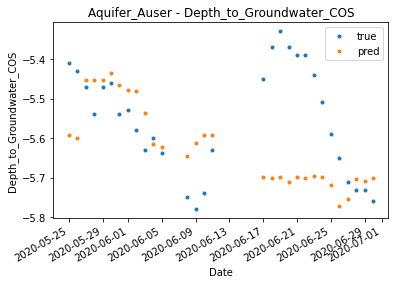

In [63]:
dfvis.plot(marker='.', linestyle='')
plt.title('%s - %s'%(body, target))
plt.ylabel(target)